# Solve BTPDE

We start by loading SpinDoctor and a Makie plotting backend.

In [1]:
using SpinDoctor
using LinearAlgebra

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

The built in geometry recipes allow for making various cell configuration. We here consider
the case of three twisted axons immersed in an extracellular space (ECS).

In [2]:
setup = CylinderSetup(;
    name = "some-very-real-axons",
    ncell = 3,
    rmin = 2.0,
    rmax = 6.0,
    dmin = 0.2,
    dmax = 0.3,
    height = 40.0,
    bend = 0.0,
    twist = π / 4,
    include_in = false,
    in_ratio = 0.6,
    ecs_shape = :convex_hull,
    ecs_ratio = 0.5,
)

CylinderSetup{Float64}("some-very-real-axons", "meshfiles", 3, 2.0, 6.0, 0.2, 0.3, 40.0, 0.0, 0.7853981633974483, false, 0.6, :convex_hull, 0.5, Inf)

We also define coefficients for the different cell compartments `:in` (axon), `:out`
(myelin), and `:ecs` (ECS).

In [3]:
coeffs = coefficients(
    setup;
    D = (; in = 0.002 * I(3), out = 0.002 * I(3), ecs = 0.002 * I(3)),
    T₂ = (; in = Inf, out = Inf, ecs = Inf),
    ρ = (; in = 1.0, out = 1.0, ecs = 1.0),
    κ = (; in_out = 1e-4, out_ecs = 1e-4, in = 0.0, out = 0.0, ecs = 0.0),
    γ = 2.67513e-4,
)

(D = StaticArrays.SMatrix{3, 3, Float64, 9}[[0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002]], T₂ = [Inf, Inf, Inf, Inf], κ = [0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0], ρ = ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], γ = 0.000267513)

The following line creates a random cell configuration for our cylinder setup, generates a
surface triangulation and calls TetGen to create a tetrahedral finite element mesh. The
compartments and boundaries will be ordered in the same way as `coeffs`.

In [4]:
mesh, = create_geometry(setup)

[ Info: Writing cell geometry to meshfiles/some-very-real-axons_cells
[ Info: Saving mesh in Tetgen output format at meshfiles/some-very-real-axons_dir/some-very-real-axons_mesh.1


(SpinDoctor.FEMesh{Float64}([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4354, 4357, 4359, 4365, 4367, 4373, 4374, 4379, 4385, 4387], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40  …  4317, 4321, 4323, 4324, 4327, 4343, 4353, 4356, 4382, 4393], [63, 64, 65, 66, 67, 68, 69, 70, 71, 72  …  4320, 4328, 4331, 4334, 4348, 4349, 4368, 4372, 4376, 4394], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4380, 4381, 4383, 4384, 4386, 4388, 4389, 4390, 4391, 4392]], [[8.093749292871824 8.331250793082493 … 3.4091413502457546 6.3976009595619; -2.7593634924150607 -1.9575718649232918 … 4.1725915115137715 1.7161398413873639; -20.0 -20.0 … 16.12163682297152 18.297385343931328], [1.4308096335351987 1.6753006757755904 … -5.791665603714815 -3.358777540178173; 3.316247173645243 4.122226125954692 … 1.9742864524240102 3.9844842045409763; -20.0 -20.0 … -3.5052905233237865 16.360647943421128], [-2.5795488528511976 -2.3648400200476036 … -3.8159757845317426 -5.517405238737518; -4.1174125299581545 -3.2974703601351685 … -5.795474337498299 -5

The resulting mesh can be plotted in 3D provided a Makie backend is loaded.

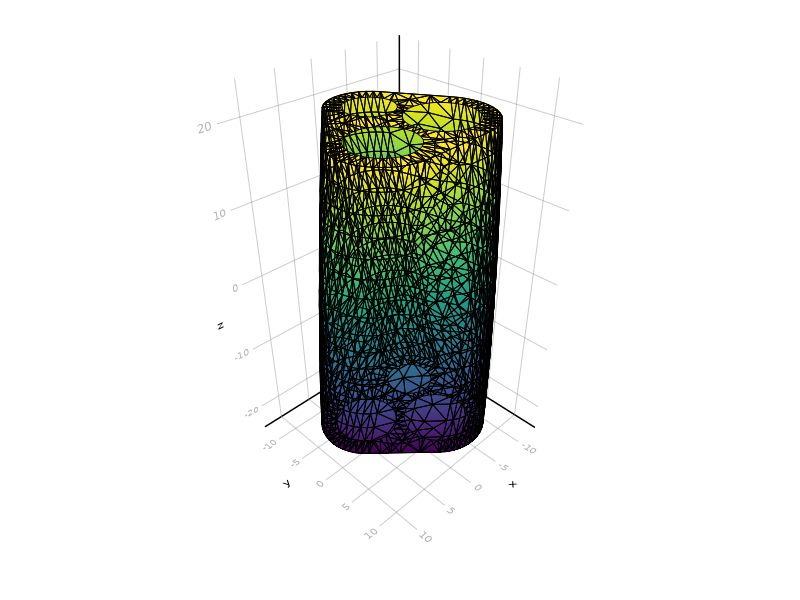

In [5]:
plot_mesh(mesh)

The mesh looks good, so we can proceed with the assembly our biological model and the
associated finite element matrices.

In [6]:
model = Model(; mesh, coeffs...)
matrices = assemble_matrices(model)

(M = sparse([1, 2, 30, 512, 515, 516, 1017, 1, 2, 3  …  5532, 5556, 5972, 6403, 6421, 7097, 7154, 7174, 7188, 7199], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199], [0.13840815926574598, 0.01713457592534713, 0.017517372544279403, 0.034174610449416165, 0.03502946918345683, 0.03455213116324646, 0.06920407963287299, 0.01713457592534713, 0.10432809021760804, 0.017517372544279423  …  0.13154178806649078, 0.379755560389543, 0.29073570822651373, 0.11175999450957795, 0.3627209021635328, 0.1884561715299395, 0.10680548566432027, 0.22206905725325965, 0.21151571847320766, 1.505630945803269], 7199, 7199), S = sparse([1, 2, 30, 512, 515, 516, 1017, 1, 2, 3  …  5532, 5556, 5972, 6403, 6421, 7097, 7154, 7174, 7188, 7199], [1, 1, 1, 1, 1, 1, 1, 2, 2, 2  …  7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199, 7199], [0.003480192139424506, -0.0010748087151826813, -0.0009214632389521176, 0.0003220775174516686, -0.0002261158373682089, -0.0009713197301242274, 

The Bloch-Torrey PDE takes a magnetic field gradient pulse sequence as an input. Here
we consider a `ScalarGradient` with a `PGSE` time profile.

In [7]:
dir = [1.0, 0.0, 0.0]
profile = PGSE(2000.0, 6000.0)
b = 1000
g = √(b / int_F²(profile)) / coeffs.γ
gradient = ScalarGradient(dir, profile, g)

SpinDoctor provides a `solve` function, which has the same base signature for all
diffusion MRI problems. The BTPDE is one such problem. They generally take a gradient
sequence as an input.

In [8]:
btpde = BTPDE(; model, matrices)
ξ = solve(btpde, gradient)

7199-element Vector{ComplexF64}:
  0.4419591615033661 + 0.3915418037672579im
  0.4252907588550909 + 0.42120234434603665im
  0.4172486729723666 + 0.44088408823586456im
 0.42228842072666894 + 0.4410354224027011im
  0.4480386924896786 + 0.39817841194972353im
 0.47694586064620165 + 0.34923751947847465im
  0.5053984464785921 + 0.29130997889761756im
  0.5300610298942222 + 0.2211621480544205im
  0.5491774360502242 + 0.13473498469616482im
  0.5620147788626055 + 0.03314701984208709im
                     ⋮
 0.32803124180489845 + 0.12144186219580079im
 0.34478648750997704 + 0.004984099837392898im
  0.3545483870621473 + 0.10895523374191968im
   0.564263452441747 - 0.31506463708152166im
  0.3155697124139586 + 0.05976449138445609im
  0.3054447732361443 + 0.04792782175726818im
  0.5370907743950968 - 0.37974425375414694im
  0.5558861922176324 - 0.18776483732682317im
 0.23457761413153272 + 0.12611352781612253im

Here, `ξ` is a vector containing the complex-valued magnetization at all degrees of freedom
at the echo time `TE`. We may compute the resulting signal as follows:

In [9]:
compute_signal(matrices.M, ξ)

5232.431122790898 + 1.0782626387561436im

The global mass matrix `M` is used to compute the integral. We may however be interested in
the compartment-wise signals. This requires splitting the magnetization field into the
respective compartments. The compartment mass matrices are also available.

In [10]:
ξ_cmpts = split_field(mesh, ξ)
compute_signal.(matrices.M_cmpts, ξ_cmpts)

4-element Vector{ComplexF64}:
 1002.7217766809699 + 21.60939784740588im
 1072.5438348579378 + 4.003437013465094im
  705.0796558094642 + 2.3859432984527382im
 2452.0858554425267 - 26.920515520567548im

The final magnetization can be visualized using the `plot_field` function.

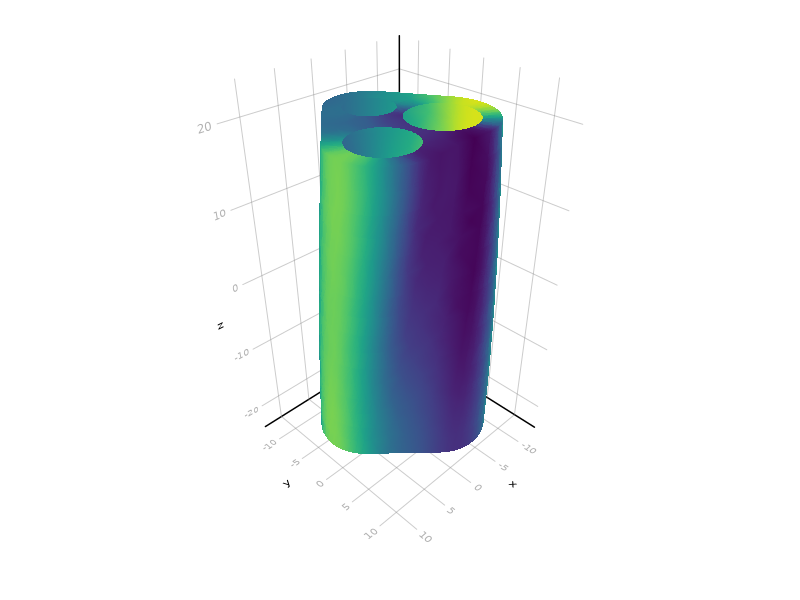

In [11]:
plot_field(mesh, ξ)

In this example, we have computed the complex transverse water proton magnetization field
using the finite element method. The measured diffusion MRI signal is the integral of this
field, and other quantities of interest, such as the apparent diffusion coefficient (ADC),
or the effective diffusion tensor, may easily be obtained from this reference field.
Directly solving the BTPDE is thus considered to be the "gold standard" for computing these
quantities, as arbitrary precision may be obtained.

However, this is also often the most computationally expensive approach. In the following
examples, we will consider some other specialized methods provided by SpinDoctor, each
having their own domains of validity, use cases, and computational footprints.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*